In [1]:
from config_path import add_to_sys_path
add_to_sys_path()  # Call the function to add path

import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex,display
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_palette('bright')
from Energy_Levels import MoleculeLevels
from Energy_Levels import branching_ratios, Calculate_TDMs,Calculate_TDM_evecs
from functools import partial
np.set_printoptions(precision=5, suppress=True)
from tabulate import tabulate
from matplotlib.collections import LineCollection

Added /Users/arianjadbabaie/Dropbox (Hutzler Lab)/HutzlerLabShared/Personal/ArianJadbabaie/Code/Molecular-Structure/Source Code to sys.path


In [2]:
%matplotlib inline

In [3]:
import copy

def select_dipole(dipole,TDM_func):
    if dipole == 'z':
        TDM = TDM_func(0)
    elif dipole == '+':
        TDM = TDM_func(1)
    elif dipole == '-':
        TDM = TDM_func(1)
    elif 'x' in dipole:
        TDMx = -1/np.sqrt(2)*(TDM_func(1)-TDM_func(-1))
        if dipole=='x':
            TDM=TDMx
        elif dipole=='x+z' or dipole=='z+x':
            TDM = 1/np.sqrt(2)*(abs(TDMx)+abs(TDM_func(0)))
    else:
        TDM = 1/np.sqrt(3)*(abs(TDM_func(-1))+abs(TDM_func(0))+abs(TDM_func(1)))
    return TDM

def lorentzian(f,f0,g,N):
    return N*(g/2)**2 /((f-f0)**2 + (g/2)**2)


def simulate_spectra(field_EB,state_g,state_e,g_idx,e_idx,ret_str =False,with_F=True,freq_array=None,diagonalize=False,T=4,origin = 0,P_adjust=False,square=True,pad=10,dipole='z',cm=True,thresh=1e-3,g=7.9/(29979.2458),dip=False,make_lorentzians=True,plot=True):
    E0, B0 = field_EB
    if diagonalize:
        G_evals,G_evecs = copy.deepcopy(state_g.eigensystem(E0,B0))
        E_evals,E_evecs = copy.deepcopy(state_e.eigensystem(E0,B0))
    else:
        G_evals,G_evecs = copy.deepcopy(state_g.evals0),copy.deepcopy(state_g.evecs0)
        E_evals,E_evecs = copy.deepcopy(state_e.evals0),copy.deepcopy(state_e.evecs0)
    TDM_func = partial(Calculate_TDMs,Ground=state_g,Excited=state_e,Ez=E0,Bz=B0,q=[-1,1])
    TDM_EB = select_dipole(dipole,TDM_func)
    if cm:
        E_evals/=29979.2458
        G_evals/=29979.2458
    E_evals+= origin
    dE_EB = np.subtract.outer(E_evals, G_evals)
    
    all_param = []
    flist = []
    TDMlist = []
    t_str_list = []
    for i in g_idx:
        vec_g = G_evecs[i,:]
        q_g = abs(vec_g).argmax()
        for j in e_idx:
            vec_e = E_evecs[j,:]
            q_e = abs(vec_e).argmax()
            Je,Me,Fe = [state_e.q_numbers[_q][q_e] for _q in ['J','M','F']]
            Pe = {1:'+',-1:'-'}[state_e.parities[j]]
            Ng,Jg,Mg,Fg = [state_g.q_numbers[_q][q_g] for _q in ['N','J','M','F']]
            Pg = {1:'+',-1:'-'}[state_g.parities[i]]
            if Me % 1 == 0:
                Me=int(Me)
                Mg = int(Mg)
#                 if N==1:
#                     boltz=1
#                 else:
#                     boltz = np.exp(-(0.352*(N*(N+1)-2)/T))
            if cm:
                boltz = np.exp(-G_evals[i]*1.439/T)
            else:
                boltz = np.exp(-4.799e-5*G_evals[i]/T)
            _TDM = TDM_EB[j,i]
            _dE = dE_EB[j,i]
            if _dE<0:
                continue
            if abs(_TDM) < thresh:
                continue
            flist.append(_dE)
            if square:
                _TDM = np.square(_TDM)
            _TDM*= boltz
            if Jg>Je and P_adjust:
                _TDM*=(2*Je+1)/(2*Jg+1)
            all_param.append([_dE,g,_TDM])
            TDMlist.append(_TDM)
            # with_F = True
            if ret_str:
                if with_F:
                    full_str = '(N={Ng}{Pg},J={Jg},F={Fg},M={Mg})->(J={Je}{Pe},F={Fe},M={Me})\nTDM={tdm}'.format(Je=Je,Fe=Fe,Me=Me,Pe=Pe,Ng=Ng,Jg=Jg,Fg=Fg,Mg=Mg,Pg=Pg,tdm=_TDM)
                else:
                    dJ = Je-Jg
                    PQR_J = {-2:'O',-1:'P', 0:'Q', 1:'R',2:'S'}[dJ]
                    dJN = Jg - Ng
                    dN = (Je-0.5) - Ng
                    PQR_N = {-2:'O',-1:'P', 0:'Q', 1:'R',2:'S'}[dN]
                    F12 = {0.5:'1',-0.5:'2'}[dJN]
                    full_str = []
                    pqr_str = r'$^{{{pqr_n}}} {{{pqr_j}}}_{{1{{{fi}}}}}({{{Ng}}}^{{{{{Pg}}}}})$'.format(pqr_n=PQR_N,pqr_j=PQR_J,fi=F12,Ng=Ng,Pg=Pg)
                    full_str.append(pqr_str)
                    qn_str = ['{Ng}, {Jg2}/2'.format(Ng=Ng,Jg2=int(Jg*2)),'{Je2}/2'.format(Je2=int(Je*2))]
                    full_str.extend(qn_str)
                    freq_str = ['{}'.format(np.round(_dE,5))]
                    full_str.extend(freq_str)
#                     '\t' + r'$N={{{Ng}}}^{{{{{Pg}}}}},J={{{Jg}}},M={{{Mg}}} \rightarrow J={{{Je}}}^{{{{{Pe}}}}},M={{{Me}}}$'.format(Je=Je,Me=Me,Pe=Pe,Ng=Ng,Jg=Jg,Mg=Mg,Pg=Pg)
                t_str_list.append(full_str)
    if flist==[]:
        flist.append(0)
        all_param.append([0,g,0])
        TDMlist.append(0)
    if make_lorentzians:
        if freq_array is None:
            fmin = min(flist)-pad*g
            fmax = max(flist)+pad*g
            n=int((fmax-fmin)/(g/20))
            freq = np.linspace(fmin,fmax,n)
        else:
            freq = freq_array
            n = len(freq_array)
        tot_lor = np.zeros(n)
        for param in all_param:
            tot_lor+=lorentzian(freq,*param)
        if dip:
            tot_lor*=-1
        if plot:
            plt.figure()
            plt.plot(freq,tot_lor)
        if ret_str:
            return flist,(freq,tot_lor),TDMlist,t_str_list
        else:
            return flist,(freq,tot_lor),TDMlist
    else:
        if ret_str:
            return flist,TDMlist,t_str_list
        else:
            return flist,TDMlist


def simulate_spectra_noM(field_EB,state_g,state_e,g_idx,e_idx,ret_str =False,with_F=True,freq_array=None,diagonalize=False,boltz_bool=True,T=4,origin = 0,P_adjust=False,pad=10,dipole='z',cm=True,thresh=1e-3,g=7.9/(29979.2458),dip=False,make_lorentzians=True,plot=True):
    E0, B0 = field_EB
    if diagonalize:
        G_evals,G_evecs = copy.deepcopy(state_g.eigensystem(E0,B0))
        E_evals,E_evecs = copy.deepcopy(state_e.eigensystem(E0,B0))
    else:
        G_evals,G_evecs = copy.deepcopy(state_g.evals0),copy.deepcopy(state_g.evecs0)
        E_evals,E_evecs = copy.deepcopy(state_e.evals0),copy.deepcopy(state_e.evecs0)
    BR_EB = branching_ratios(state_g,state_e,E0,B0).T
    if cm:
        E_evals/=29979.2458
        G_evals/=29979.2458
    E_evals+= origin
    dE_EB = np.subtract.outer(E_evals, G_evals)
    
    all_param = []
    flist = []
    BRlist = []
    t_str_list = []
    for i in g_idx:
        vec_g = G_evecs[i,:]
        q_g = abs(vec_g).argmax()
        for j in e_idx:
            vec_e = E_evecs[j,:]
            q_e = abs(vec_e).argmax()
            Je,Me,Fe = [state_e.q_numbers[_q][q_e] for _q in ['J','M','F']]
            Pe = {1:'+',-1:'-'}[state_e.parities[j]]
            Ng,Jg,Mg,Fg = [state_g.q_numbers[_q][q_g] for _q in ['N','J','M','F']]
            Pg = {1:'+',-1:'-'}[state_g.parities[i]]
            if Me % 1 == 0:
                Me=int(Me)
                Mg = int(Mg)
#                 if N==1:
#                     boltz=1
#                 else:
#                     boltz = np.exp(-(0.352*(N*(N+1)-2)/T))
            if cm:
                boltz = np.exp(-G_evals[i]*1.439/T)
            else:
                boltz = np.exp(-4.799e-5*G_evals[i]/T)
            _BR =BR_EB[j,i]
            _dE = dE_EB[j,i]
            if _dE<0:
                continue
            if abs(_BR) < thresh:
                continue
            flist.append(_dE)
            # if square:
            #     _TDM = np.square(_TDM)
            if boltz_bool:
                _BR*= boltz
            if Jg>Je and P_adjust:
                _BR*=(2*Je+1)/(2*Jg+1)
            all_param.append([_dE,g,_BR])
            BRlist.append(_BR)
            # with_F = True
            if ret_str:
                if with_F:
                    full_str = '(J={Jg},F={Fg})->(J={Je}{Pe},F={Fe})\nBR={br}'.format(Je=Je,Fe=Fe,Pe=Pe,Ng=Ng,Jg=Jg,Fg=Fg,Pg=Pg,br=_BR)
                    # full_str = '(N={Ng}{Pg},J={Jg},F={Fg})->(J={Je}{Pe},F={Fe})\nBR={br}'.format(Je=Je,Fe=Fe,Pe=Pe,Ng=Ng,Jg=Jg,Fg=Fg,Pg=Pg,br=_BR)
                else:
                    dJ = Je-Jg
                    PQR_J = {-2:'O',-1:'P', 0:'Q', 1:'R',2:'S'}[dJ]
                    dJN = Jg - Ng
                    dN = (Je-0.5) - Ng
                    PQR_N = {-2:'O',-1:'P', 0:'Q', 1:'R',2:'S'}[dN]
                    F12 = {0.5:'1',-0.5:'2'}[dJN]
                    full_str = []
                    pqr_str = r'$^{{{pqr_n}}} {{{pqr_j}}}_{{1{{{fi}}}}}({{{Ng}}}^{{{{{Pg}}}}})$'.format(pqr_n=PQR_N,pqr_j=PQR_J,fi=F12,Ng=Ng,Pg=Pg)
                    full_str.append(pqr_str)
                    qn_str = ['{Ng}, {Jg2}/2'.format(Ng=Ng,Jg2=int(Jg*2)),'{Je2}/2'.format(Je2=int(Je*2))]
                    full_str.extend(qn_str)
                    freq_str = ['{}'.format(np.round(_dE,5))]
                    full_str.extend(freq_str)
#                     '\t' + r'$N={{{Ng}}}^{{{{{Pg}}}}},J={{{Jg}}},M={{{Mg}}} \rightarrow J={{{Je}}}^{{{{{Pe}}}}},M={{{Me}}}$'.format(Je=Je,Me=Me,Pe=Pe,Ng=Ng,Jg=Jg,Mg=Mg,Pg=Pg)
                t_str_list.append(full_str)
    if flist==[]:
        flist.append(0)
        all_param.append([0,g,0])
        BRlist.append(0)
    if make_lorentzians:
        if freq_array is None:
            fmin = min(flist)-pad*g
            fmax = max(flist)+pad*g
            n=int((fmax-fmin)/(g/20))
            freq = np.linspace(fmin,fmax,n)
        else:
            freq = freq_array
            n = len(freq_array)
        tot_lor = np.zeros(n)
        for param in all_param:
            tot_lor+=lorentzian(freq,*param)
        if dip:
            tot_lor*=-1
        if plot:
            plt.figure()
            plt.plot(freq,tot_lor)
        if ret_str:
            return flist,(freq,tot_lor),BRlist,t_str_list
        else:
            return flist,(freq,tot_lor),BRlist
    else:
        if ret_str:
            return flist,BRlist,t_str_list
        else:
            return flist,BRlist

In [4]:
N_g = np.arange(0,7)
N_e = np.arange(1,9)

In [5]:
g = MoleculeLevels.initialize_state('YbOH','174','X000',N_g,M_values = 'none',I=[0,1/2],S=1/2,round=8,P_values=[1/2])
e = MoleculeLevels.initialize_state('YbOH','174','A000',N_e,M_values = 'none',I=[0,1/2],S=1/2,round=8,P_values=[1/2])
g.eigensystem(0,1e-3);
e.eigensystem(0,1e-3);
# gidx = g.select_q({'N':[0,1,2,3,4,5,7,8,9,10,11]})
# eidx = e.select_q({'J':[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]})

Cannot construct decoupled basis without M values
Cannot construct decoupled basis without M values


In [6]:
g.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5755.56,
 'Gamma_SR': 175.38,
 'bF': 96.3,
 'c': 19,
 'muE': 1.96834092,
 'D': 0.004197094412}

In [7]:
e.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5726.471605811175,
 'ASO': 0.0,
 'h1/2': 0,
 'a': 9.5,
 'bF': 0,
 'c': 0,
 'd': -9,
 'p+2q': -12312.770346461299,
 'q': 0,
 'D': 0.004197094412,
 'p2q_D': 0.005696056702,
 'g_lp': -0.724,
 'muE': 0.21646716,
 'Origin': 13284.618014811987}

In [8]:
new_params=e.parameters
new_params['d']=-9
new_params['h1/2']=0
e.update_params(new_params)

Successfully converted eigenvectors from bBJ to aBJ


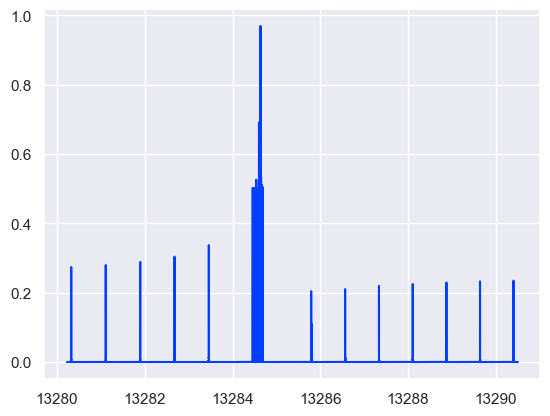

In [9]:
gidx = g.select_q({'N':N_g.tolist()})
eidx = e.select_q({'J':(N_e-1/2).tolist()})
flist,(freq,tot_lor),BRlist,t_str_list = simulate_spectra_noM([0,0],g,e,gidx,eidx,ret_str =True,freq_array=None,boltz_bool=False,diagonalize=False,T=2,origin = e.parameters['Origin'],P_adjust=False,pad=300,dipole='all',cm=True,thresh=1e-5,g=6/(29979.2458),dip=False,make_lorentzians=True,plot=True)

0
(J=0.5,F=1.0)->(J=0.5+,F=0.0)
13284.636760623529
0.47628580873781834 

1
(J=0.5,F=1.0)->(J=0.5+,F=1.0)
13284.63677286468
0.48864217586472797 

2
(J=0.5,F=0.0)->(J=0.5+,F=1.0)
13284.635677092076
0.22382153909926855 

3
(J=1.5,F=1.0)->(J=0.5+,F=0.0)
13284.628478086752
0.5237141940322405 

4
(J=1.5,F=1.0)->(J=0.5+,F=1.0)
13284.628490327903
0.011357825079241558 

5
(J=1.5,F=2.0)->(J=0.5+,F=1.0)
13284.626711902538
0.2761709002925938 



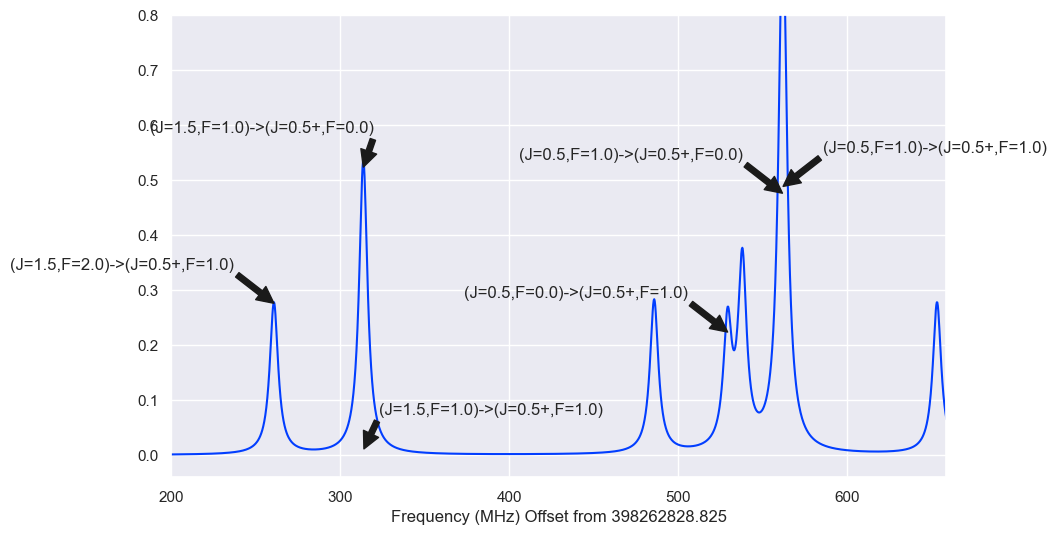

In [11]:
c=29979.2458
origin = e.parameters['Origin']
plt.figure(figsize=(10,6))
MHz = lambda x:c*(x-origin)
fMHz = MHz(freq) 
plt.plot(fMHz,tot_lor)

#Wavenumbers of interest
plt.xlim(200,MHz(13284.64))
# plt.axvline(MHz(13284.63676),color='k',linestyle=':')
# plt.axvline(MHz(13284.63677),color='k',linestyle=':')
# plt.axvline(MHz(13284.63568),color='k',linestyle=':')
# plt.axvline(MHz(13284.62848),color='k',linestyle=':')
# plt.axvline(MHz(13284.62849),color='k',linestyle=':')
# plt.axvline(MHz(13284.62671),color='k',linestyle=':')
plt.ticklabel_format(useOffset=False)
plt.xlabel('Frequency (MHz) Offset from {}'.format(np.round(c*(origin),3)))
plt.ylim(-0.04,0.8)

i=0
side = [-3,3,-3,-2,2.5,-3]
lc_lines = []
for tstr,line in zip(t_str_list,flist):
    if 'J=0.5+,' in tstr:
        BR = tstr.split('\n')[-1].split('=')[-1]
        print(i)
        plt.annotate(tstr.split('\n')[0],xy=(MHz(line),float(BR)),ha='center',va='center',xytext=(MHz(line)+30*side[i],float(BR)+0.07),arrowprops={'color':'k'})
        i+=1
        print(tstr.split('\n')[0])
        print(line)
        print(BR,'\n')
        lc_lines.append(line)

In [20]:
help(tstr.split)

Help on built-in function split:

split(sep=None, maxsplit=-1) method of builtins.str instance
    Return a list of the substrings in the string, using sep as the separator string.
    
      sep
        The separator used to split the string.
    
        When set to None (the default value), will split on any whitespace
        character (including \n \r \t \f and spaces) and will discard
        empty strings from the result.
      maxsplit
        Maximum number of splits (starting from the left).
        -1 (the default value) means no limit.
    
    Note, str.split() is mainly useful for data that has been intentionally
    delimited.  With natural text that includes punctuation, consider using
    the regular expression module.



In [29]:
gM = MoleculeLevels.initialize_state('YbOH','174','X000',[0,1,2,3],M_values = 'all',I=[0,0],S=1/2,round=8,P_values=[1/2])
# eM.update_params(new_params)

In [30]:
eM = MoleculeLevels.initialize_state('YbOH','174','A000',[1,2,3],M_values = 'all',I=[0,1/2],S=1/2,round=8,P_values=[1/2,3/2])
# eM.update_params(new_params)

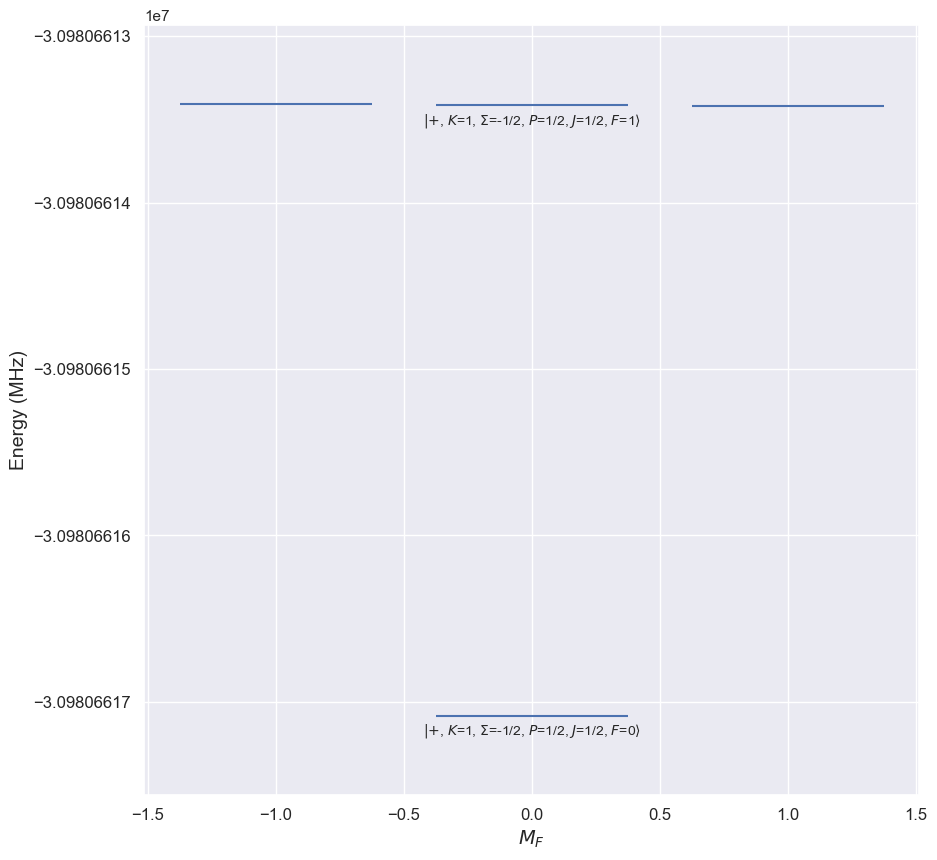

In [31]:
eM.display_levels(0,1e-3,'F',idx=eM.select_q({'J':0.5},parity='+'),parity=True)
plt.ticklabel_format(useOffset=False)

In [6]:
help(eM.gen_state_str)

Help on method gen_state_str in module Energy_Levels:

gen_state_str(vector_idx, evecs=None, basis=None, label_q=None, parity=False, single=False, thresh=0.01, show_coeff=True, new_line=False, round=None, frac='') method of Energy_Levels.MoleculeLevels instance



In [16]:
eM.select_q({'J':1/2},parity='+')

array([12, 13, 14, 15])

In [27]:
display(Latex(eM.gen_state_str(eM.select_q({'J':1/2,'M':0},parity='+')[0],basis='bBJ',label_q=['N','J','K'])))

<IPython.core.display.Latex object>

In [40]:
for i in gM.select_q({'J':5/2,'M':0}):
    display(Latex(gM.gen_state_str(i,basis='aBJ',label_q=['J','Sigma'])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [42]:
for i in gM.select_q({'J':5/2,'M':0}):
    display(Latex(gM.gen_state_str(i,basis='bBJ',label_q=['N','J','K'])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:


11882.96671 - 11882.59973

In [16]:
eM.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5726.471605811175,
 'ASO': 0.0,
 'h1/2': 0,
 'a': 9.5,
 'bF': 0,
 'c': 0,
 'd': -9,
 'p+2q': -12312.770346461299,
 'q': 0,
 'D': 0.004197094412,
 'p2q_D': 0.005696056702,
 'g_lp': -0.724,
 'muE': 0.21646716,
 'Origin': 13284.618014811987}

In [53]:
e.evals0

array([  -429.99947,   -429.66492,  10591.65073,  10593.92092,
        11879.77071,  11892.09973,  33067.07307,  33070.07529,
        35215.81962,  35223.15139,  66995.21793,  66998.58459,
        70004.378  ,  70010.6339 , 112375.62328, 112379.21036,
       116245.30347, 116251.08023, 169207.81847, 169211.55373,
       173938.26086, 173943.76505, 237491.25332, 237495.09518,
       243082.79304, 243088.12098, 317225.28398, 317229.20627,
       323678.3351 , 323683.53958, 408409.1688 , 408413.15417,
       415724.21846, 415729.33161, 519219.6717 , 519224.71529])

In [17]:
lc_MHz = MHz(np.array(sorted(lc_lines)))
lc_MHz-=lc_MHz[0]
lc_MHz= np.delete(lc_MHz,2)
print(lc_MHz)
print(lc_MHz[1:]-lc_MHz[:-1])

[  0.       52.94887 268.76962 301.25308 301.62006]
[ 52.94887 215.82075  32.48346   0.36698]


In [14]:
tstr.split('\n')[1].split('=')[-1]

'0.23333310486192418'

In [15]:
display(Latex(e.gen_state_str(5, thresh=1e-5,label_q=['P','J','F'])))

<IPython.core.display.Latex object>

In [16]:
display(Latex(e.gen_state_str(4, thresh=1e-5,label_q=['P','J','F'])))

<IPython.core.display.Latex object>

In [17]:
for tstr,line in zip(t_str_list,flist):
    if 'J=0.5+,' in tstr:
        print(tstr)
        print(line,'\n')

(J=0.5,F=1.0)->(J=0.5+,F=0.0)
BR=0.4762857413808356
13284.636760684702 

(J=0.5,F=1.0)->(J=0.5+,F=1.0)
BR=0.49014233154315795
13284.636772932992 

(J=0.5,F=0.0)->(J=0.5+,F=1.0)
BR=0.22054759039660846
13284.635677160388 

(J=1.5,F=1.0)->(J=0.5+,F=0.0)
BR=0.5237141199678714
13284.628478147924 

(J=1.5,F=1.0)->(J=0.5+,F=1.0)
BR=0.009857643703166163
13284.628490396215 

(J=1.5,F=2.0)->(J=0.5+,F=1.0)
BR=0.27944364429418567
13284.62671197085 



In [18]:
leakage = np.array([2.43e-5,3.82e-6,9.16e-7,1.09e-6,4.20e-6,2.58e-5])
d_vals = np.array([-50,-20,-10,10,20,50])

In [19]:
for tstr,line in zip(t_str_list,flist):
    if line>13284.62 and line<13284.65:
        print(tstr)
        print(line,'\n')

(J=0.5,F=1.0)->(J=0.5+,F=0.0)
BR=0.4762857413808356
13284.636760684702 

(J=0.5,F=1.0)->(J=0.5+,F=1.0)
BR=0.49014233154315795
13284.636772932992 

(J=0.5,F=0.0)->(J=0.5+,F=1.0)
BR=0.22054759039660846
13284.635677160388 

(J=1.5,F=1.0)->(J=0.5+,F=0.0)
BR=0.5237141199678714
13284.628478147924 

(J=1.5,F=1.0)->(J=0.5+,F=1.0)
BR=0.009857643703166163
13284.628490396215 

(J=1.5,F=2.0)->(J=0.5+,F=1.0)
BR=0.27944364429418567
13284.62671197085 

(J=1.5,F=1.0)->(J=1.5-,F=1.0)
BR=0.4444667943049587
13284.648895178447 

(J=1.5,F=1.0)->(J=1.5-,F=2.0)
BR=0.05266187409437113
13284.648989304507 

(J=2.5,F=2.0)->(J=1.5-,F=1.0)
BR=0.33428624635846305
13284.63586280038 

(J=2.5,F=2.0)->(J=1.5-,F=2.0)
BR=0.0034919189722387644
13284.63595692644 

(J=2.5,F=3.0)->(J=1.5-,F=2.0)
BR=0.2806455443733192
13284.634288766474 

(J=3.5,F=3.0)->(J=2.5+,F=2.0)
BR=0.3000902339673417
13284.64140868775 

(J=3.5,F=3.0)->(J=2.5+,F=3.0)
BR=0.0017738116233672904
13284.641526442852 

(J=3.5,F=4.0)->(J=2.5+,F=3.0)
BR=0.2758459

In [20]:
0.063+0.063+0.084

0.21000000000000002

In [21]:
41.7226-41.0988

0.6238000000000028

In [22]:
sorted(flist)

[13280.286577821755,
 13280.323061727011,
 13280.323261785541,
 13280.324492495156,
 13281.079478239526,
 13281.110105201855,
 13281.110314339261,
 13281.111522675017,
 13281.870467821025,
 13281.895235147493,
 13281.895460289546,
 13281.896632976004,
 13282.659543846641,
 13282.678447104825,
 13282.678708389396,
 13282.679812811251,
 13283.446707301853,
 13283.45973967992,
 13283.46017332374,
 13283.461042315625,
 13284.45842431129,
 13284.458614408952,
 13284.45999067302,
 13284.460180770682,
 13284.487352398977,
 13284.487546596667,
 13284.488930481168,
 13284.489124678857,
 13284.496664675939,
 13284.497905346421,
 13284.498095444083,
 13284.514332672294,
 13284.514532730824,
 13284.515927581235,
 13284.516127639765,
 13284.519751641186,
 13284.520974916659,
 13284.521169114349,
 13284.53936564958,
 13284.539574786986,
 13284.540894966232,
 13284.540986829732,
 13284.541195967138,
 13284.542092736214,
 13284.542292794744,
 13284.560099225322,
 13284.561255794342,
 13284.56146493174